In [1]:
# !pip install beautifulsoup4

In [2]:
import os, re
import pandas as pd
from bs4 import BeautifulSoup
from collections import Counter
from nltk.corpus import stopwords

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt

import numpy as np

from sklearn.metrics.pairwise import cosine_similarity

from sklearn.cluster import AgglomerativeClustering

from wordcloud import WordCloud

In [3]:
# Define the directory containing the job posting HTML files
job_postings_dir = "./data/job_postings"

# Prepare a list to store the file name and its parsed text
records = []

# Loop over each file in the job_postings directory
for file_name in os.listdir(job_postings_dir):
    if file_name.endswith(".html"):
        file_path = os.path.join(job_postings_dir, file_name)
        with open(file_path, 'r', encoding='utf-8') as f:
            html_content = f.read()

            # Parse HTML with BeautifulSoup
            soup = BeautifulSoup(html_content, 'html.parser')

            # Extract text from the HTML
            parsed_text = soup.get_text(separator=' ', strip=True)

            # Store results
            records.append({
                "filename": file_name,
                "parsed_text": parsed_text
            })

# Create a pandas DataFrame from the records
df_jobs = pd.DataFrame(records, columns=["filename", "parsed_text"])

# Display the first few rows of the DataFrame
df_jobs.head()


,filename,parsed_text
0,fb17842d02292e83.html,"Python Systems Engineer - San Francisco, CA 94..."
1,06e2c7659a3199e9.html,Santa Clara 4-H Community Ed Specialist 3 - Oa...
2,c49bf5a9b76b6943.html,Senior Software Airworthiness Engineer (2019-0...
3,0c569e6055392385.html,"Data Center Technician - Hayward, CA Data Cent..."
4,0a22c5c79af5fcf8.html,"Data Architect - Raleigh, NC 27609 Data Archit..."


In [4]:

tags_counter = Counter()

for file_name in os.listdir(job_postings_dir):
    if file_name.endswith(".html"):
        file_path = os.path.join(job_postings_dir, file_name)
        with open(file_path, 'r', encoding='utf-8') as f:
            html_content = f.read()
            soup = BeautifulSoup(html_content, 'html.parser')
            
            # Count all tag types
            for tag in soup.find_all():
                tags_counter[tag.name] += 1

# Convert the Counter to a DataFrame to visualize
df_tags = pd.DataFrame(tags_counter.items(), columns=['tag', 'count']).sort_values(by='count', ascending=False)
df_tags.head(10)


,tag,count
11,li,25197
5,div,14149
12,p,11627
7,br,10756
9,b,7793
10,ul,5078
4,h2,2067
0,html,1458
2,title,1458
1,head,1458


In [5]:
df_tags.shape

(16, 2)

In [6]:

skill_keywords = ["python", "sql", "machine learning", "data analysis", "statistics", "nlp", 
                  "deep learning", "cloud", "aws", "azure", "gcp", "etl", "excel", "power bi"]

skill_tag_counts = Counter()

for file_name in os.listdir(job_postings_dir):
    if file_name.endswith(".html"):
        file_path = os.path.join(job_postings_dir, file_name)
        with open(file_path, 'r', encoding='utf-8') as f:
            html_content = f.read()
            soup = BeautifulSoup(html_content, 'html.parser')
            
            # For each HTML element, check if it contains any skill keywords
            for tag in soup.find_all():
                tag_text = tag.get_text(separator=' ', strip=True).lower()
                if any(skill in tag_text for skill in skill_keywords):
                    skill_tag_counts[tag.name] += 1

df_skill_tags = pd.DataFrame(skill_tag_counts.items(), columns=['tag', 'count']).sort_values(by='count', ascending=False)
df_skill_tags

,tag,count
7,li,4892
5,div,2957
6,ul,2078
0,html,1346
3,body,1346
9,p,998
4,h2,149
1,head,128
2,title,128
8,b,106


In [7]:
tags_of_interest = ["li", "div", "ul", "p", "h2", "head", "title", "b"]

# Initialize columns (set them to 0 for starters)
for t in tags_of_interest:
    col_name = f"{t}_skill_count"
    df_jobs[col_name] = 0

# Also track total skill mentions in entire doc
df_jobs["total_skill_count"] = 0

# Directory with HTML job postings
job_postings_dir = "./data/job_postings"

def count_skills_in_text(text, skill_list):
    """
    Given a piece of text, return how many skill keywords appear.
    We count each skill presence once, even if it appears multiple times.
    If you want to count duplicates, you'd do something more thorough.
    """
    text_lower = text.lower()
    count = 0
    for skill in skill_list:
        if skill in text_lower:
            count += 1
    return count

# Iterate through df_jobs
for idx, row in df_jobs.iterrows():
    filename = row["filename"]
    file_path = os.path.join(job_postings_dir, filename)
    
    # Open and parse the HTML
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            html_content = f.read()
        soup = BeautifulSoup(html_content, "html.parser")
    except FileNotFoundError:
        # If the file doesn't exist or there's an error, skip
        continue
    
    # Track a total skill count across entire doc
    total_skills_in_doc = count_skills_in_text(soup.get_text(separator=' ', strip=True), skill_keywords)
    df_jobs.loc[idx, "total_skill_count"] = total_skills_in_doc
    
    # Now, for each tag_of_interest, find all tags and sum skill counts
    for t in tags_of_interest:
        skill_count_for_tag = 0
        
        # find_all(...) gets all occurrences of that tag
        tags_found = soup.find_all(t)
        
        # Sum up how many skill keywords are present in each tag's text
        for tag_element in tags_found:
            tag_text = tag_element.get_text(separator=' ', strip=True)
            # Either increment by 1 for each skill found
            # or do a cumulative sum if you want to count duplicates
            skill_count_for_tag += count_skills_in_text(tag_text, skill_keywords)
        
        col_name = f"{t}_skill_count"
        df_jobs.loc[idx, col_name] = skill_count_for_tag


tag_columns = [f"{t}_skill_count" for t in tags_of_interest]
corr_matrix = df_jobs[tag_columns + ["total_skill_count"]].corr()
corr_matrix

,li_skill_count,div_skill_count,ul_skill_count,p_skill_count,h2_skill_count,head_skill_count,title_skill_count,b_skill_count,total_skill_count
li_skill_count,1.000000,0.214475,0.831619,0.067449,0.100034,0.129614,0.129614,0.036548,0.763510
div_skill_count,0.214475,1.000000,0.299251,-0.009092,0.024719,0.045010,0.045010,-0.025377,0.270085
ul_skill_count,0.831619,0.299251,1.000000,0.121295,0.073415,0.093643,0.093643,0.057626,0.654729
p_skill_count,0.067449,-0.009092,0.121295,1.000000,0.098797,0.119690,0.119690,0.237086,0.244742
h2_skill_count,0.100034,0.024719,0.073415,0.098797,1.000000,0.941607,0.941607,0.140750,0.113611
head_skill_count,0.129614,0.045010,0.093643,0.119690,0.941607,1.000000,1.000000,0.078656,0.134332
title_skill_count,0.129614,0.045010,0.093643,0.119690,0.941607,1.000000,1.000000,0.078656,0.134332
b_skill_count,0.036548,-0.025377,0.057626,0.237086,0.140750,0.078656,0.078656,1.000000,0.045698
total_skill_count,0.763510,0.270085,0.654729,0.244742,0.113611,0.134332,0.134332,0.045698,1.000000


In [8]:
# Step 1: Read resume.txt
with open("./data/resume.txt", "r", encoding="utf-8") as f:
    resume_text = f.read()
    
print("Resume loaded. Characters in resume:", len(resume_text))

# Define potential skill keywords (you can expand this list)
potential_skills = [
    "python", "r", "sql", "java", "c++", "machine learning", "ml", 
    "deep learning", "nlp", "ai", "tensorflow", "pytorch", 
    "data analysis", "etl", "spark", "hadoop", "excel", 
    "tableau", "power bi", "aws", "azure", "gcp", "matplotlib", "numpy", 
    "pandas", "scikit-learn", "pyspark", "dbscan", "plotly", "gcp", 
    "scipy", "pandas", "k-means", "geonamescache", "basemap", "pca"
    "svd", "nlp", "clustering", "algorithms", "statistic", "statistical",
    "analysis", "visualization", 
]

# Convert resume text to lower case for matching
resume_lower = resume_text.lower()

# Determine which skill keywords actually appear in the resume
resume_skills = set()
for skill in potential_skills:
    if skill in resume_lower:
        resume_skills.add(skill)

print("Skills identified in resume:")
for skill in sorted(resume_skills):
    print("-", skill)

# 3. COUNT HOW MANY RESUME SKILLS ARE MENTIONED IN EACH JOB POST
def count_resume_skill_matches(posting_text, resume_skills):
    text_lower = posting_text.lower()
    return sum(skill in text_lower for skill in resume_skills)

df_jobs["skill_count"] = df_jobs["parsed_text"].apply(
    lambda text: count_resume_skill_matches(text, resume_skills)
)

# 4. DEFINE THRESHOLDS AND CREATE A FLAG
min_skill_matches = 3  # too few => possibly underqualified
max_skill_matches = 8  # too many => possibly overqualified
df_jobs["is_in_sweet_spot"] = (
    (df_jobs["skill_count"] >= min_skill_matches) & 
    (df_jobs["skill_count"] <= max_skill_matches)
)

Resume loaded. Characters in resume: 683
Skills identified in resume:
- algorithms
- analysis
- basemap
- clustering
- dbscan
- geonamescache
- k-means
- matplotlib
- nlp
- numpy
- pandas
- r
- scikit-learn
- scipy
- statistic
- statistical
- visualization


In [9]:
df_jobs.sample(5)

,filename,parsed_text,li_skill_count,div_skill_count,ul_skill_count,p_skill_count,h2_skill_count,head_skill_count,title_skill_count,b_skill_count,total_skill_count,skill_count,is_in_sweet_spot
109,b16865affc0576ed.html,"Data Scientist - Pittsburgh, PA Data Scientist...",0,0,0,3,0,0,0,0,3,4,True
660,b21ee514f5e51b1d.html,Languages and Compiler Engineer - San Francisc...,1,0,0,0,0,0,0,0,1,2,False
881,e8397bedcb064ba9.html,"Data Engineer - Redwood City, CA Data Engineer...",8,0,0,0,0,0,0,0,6,3,True
935,f9afb21b4a0dca74.html,"Data Engineer - Pasadena, CA Data Engineer - P...",3,4,3,0,0,0,0,0,3,2,False
1380,142fb4a5703ac62c.html,"Project Manager - New York, NY Project Manager...",0,0,0,0,0,0,0,0,0,2,False


In [10]:
df_jobs.is_in_sweet_spot.value_counts()

is_in_sweet_spot
True     997
False    461
Name: count, dtype: int64

In [11]:
df_jobs.loc[df_jobs['is_in_sweet_spot'] == True, ['parsed_text', 'is_in_sweet_spot']].sample(5)

,parsed_text,is_in_sweet_spot
640,"Intern - Clinical Toxicology - Salt Lake City,...",True
451,"Lead Data Scientist - Portland, OR 97239 Lead ...",True
753,"Product Data Scientist - New York, NY Product ...",True
461,Industrial Engineer University Grad - Data Sci...,True
652,"Data Analyst E-Commerce - San Diego, CA 92121 ...",True


In [12]:
df_jobs.loc[df_jobs['is_in_sweet_spot'] == False, ['parsed_text', 'is_in_sweet_spot']].sample(5)

,parsed_text,is_in_sweet_spot
235,"NoSQL Database Administrator - Houston, TX NoS...",False
1451,"Dean, Mathematics, Statistics and Engineering ...",False
708,"Full Stack Software Engineer - Menlo Park, CA ...",False
1056,"Associate Scientist, Data Science - Irving, TX...",False
499,Staff Nurse II - Medical/Surgical-Day-Benefitt...,False


In [13]:
# 1. Setup stopwords, excluding 'r' if you want to keep R as a skill
stop_words = set(stopwords.words('english'))
if "r" in stop_words:
    stop_words.remove("r")

def tokenize_and_clean(text):
    """
    1. Lowercase
    2. Split on non-word chars
    3. Remove empty splits
    4. Filter out English stopwords (except 'r')
    5. Return a list of clean tokens
    """
    text = text.lower()
    tokens = re.split(r"\W+", text)
    tokens = [t for t in tokens if t]  # remove empty strings
    
    clean_tokens = []
    for tok in tokens:
        # skip if it's in stopwords
        if tok in stop_words:
            continue
        clean_tokens.append(tok)
    
    return clean_tokens

# 2. Define the tags we want to parse
tags_of_interest = ["li", "lu", "div",  "p",]

# 3. We'll add one new column, "tag_tokens", to store aggregated tokens
#    for each job posting (unique across all those tags).
df_jobs["tag_tokens"] = [[] for _ in range(len(df_jobs))]

job_postings_dir = "./data/job_postings"

# 4. Iterate through each row, parse tags of interest, tokenize, and store results
for idx, row in df_jobs.iterrows():
    filename = row["filename"]
    file_path = os.path.join(job_postings_dir, filename)
    
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            html_content = f.read()
    except FileNotFoundError:
        # If the file is missing, skip or handle as needed
        continue
    
    # Parse HTML
    soup = BeautifulSoup(html_content, "html.parser")
    
    # Use a set to avoid duplicate tokens across tags
    tokens_aggregate = set()
    
    for tag_name in tags_of_interest:
        elements = soup.find_all(tag_name)
        for el in elements:
            text = el.get_text(separator=" ", strip=True)
            tokens = tokenize_and_clean(text)
            # Add them to the set so we don't get duplicates
            tokens_aggregate.update(tokens)
    
    # Convert set back to list for storing in df_jobs
    df_jobs.at[idx, "tag_tokens"] = list(tokens_aggregate)

# 5. Check results
df_jobs.sample(5).T

,1206,1196,661,258,344
filename,8f7fa20152756b23.html,ac94ef7b1f624c7e.html,e5c2794569941270.html,a016e7a3bd2c548e.html,d8786aa78d2b7f04.html
parsed_text,Data Scientist / Natural Language Processing (...,"Data Scientist (Analytics) - Los Angeles, CA D...","Full-Stack Application Developer - Boston, MA ...","Director, Client Solutions - Washington, DC 20...",Business Reporting and Data Analyst - Westlake...
li_skill_count,10,3,9,1,3
div_skill_count,0,15,0,3,0
ul_skill_count,9,3,9,1,2
p_skill_count,3,0,2,0,1
h2_skill_count,1,0,0,0,0
head_skill_count,1,0,0,0,0
title_skill_count,1,0,0,0,0
b_skill_count,1,0,0,0,0


In [14]:
df_jobs.loc[df_jobs["tag_tokens"].apply(len) == 0].shape

(56, 14)

In [15]:
df_jobs_model = df_jobs.loc[(df_jobs["tag_tokens"].apply(len) != 0) & (df_jobs["is_in_sweet_spot"] == True)].copy()
df_jobs_model = df_jobs_model[['filename', 'tag_tokens']].copy()
df_jobs_model.shape

(967, 2)

In [16]:
df_jobs_model.info()

<class 'pandas.core.frame.DataFrame'>
Index: 967 entries, 4 to 1457
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   filename    967 non-null    object
 1   tag_tokens  967 non-null    object
dtypes: object(2)
memory usage: 22.7+ KB


### k-means model

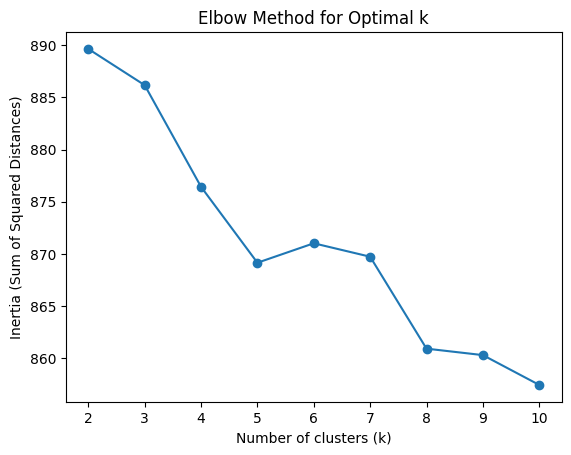

In [17]:
df = df_jobs_model.copy()

# Convert list of tokens to a single string per row
# so that TfidfVectorizer or CountVectorizer can process it
df["tag_text"] = df["tag_tokens"].apply(lambda tokens: " ".join(tokens))

pipeline = Pipeline([
    ("tfidf", TfidfVectorizer(min_df=5, max_df=0.8)),
    ("kmeans", KMeans(n_clusters=5, random_state=42))
])

# Elow plot for optimal k-clusters
X = df["tag_text"]  # our documents

k_values = range(2, 11)  # e.g., 2..10
inertias = []

for k in k_values:
    temp_pipeline = Pipeline([
        ("tfidf", TfidfVectorizer()),
        ("kmeans", KMeans(n_clusters=k, random_state=42))
    ])
    temp_pipeline.fit(X)
    
    # after fitting, we can access the kmeans step
    model_kmeans = temp_pipeline.named_steps["kmeans"]
    inertias.append(model_kmeans.inertia_)

# Plot the elbow
plt.figure()
plt.plot(k_values, inertias, marker='o')
plt.title("Elbow Method for Optimal k")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia (Sum of Squared Distances)")
plt.show()

In [18]:
optimal_k = 5 # for example, chosen based on elbow
final_pipeline = Pipeline([
    ("tfidf", TfidfVectorizer()),
    ("kmeans", KMeans(n_clusters=optimal_k, random_state=42))
])
final_pipeline.fit(X)

df["k_means_cluster_label"] = final_pipeline.predict(X)
df.head()

,filename,tag_tokens,tag_text,k_means_cluster_label
4,0a22c5c79af5fcf8.html,"[veteran, perform, run, military, acumen, bach...",veteran perform run military acumen bachelors ...,0
6,37656895b590121e.html,"[veteran, run, availability, ways, depends, 87...",veteran run availability ways depends 87653 sc...,0
7,6172582f734a32b4.html,"[engineering, veteran, team, qualified, resear...",engineering veteran team qualified researcher ...,0
9,8d51798afdc418c8.html,"[stakeholdersthroughout, improvement, needs, v...",stakeholdersthroughout improvement needs value...,1
10,2908dca57a2450ac.html,"[key, team, identifying, risk, able, concepts,...",key team identifying risk able concepts clearl...,1


In [19]:
df.k_means_cluster_label.value_counts()

k_means_cluster_label
1    547
0    273
3    111
2     26
4     10
Name: count, dtype: int64

### Cosine similarity clustering

In [20]:
vectorizer = TfidfVectorizer()
X_tfidf = vectorizer.fit_transform(df["tag_text"])

similarity_matrix = cosine_similarity(X_tfidf)  # shape: (967, 967)
distance_matrix = 1 - similarity_matrix         # shape: (967, 967)

n_clusters = 5
agglo = AgglomerativeClustering(
    n_clusters=n_clusters,
    metric='manhattan',
    linkage='complete',
    distance_threshold=None
)
labels = agglo.fit_predict(distance_matrix)

df["agglo_cluster_label"] = labels
df.head()

,filename,tag_tokens,tag_text,k_means_cluster_label,agglo_cluster_label
4,0a22c5c79af5fcf8.html,"[veteran, perform, run, military, acumen, bach...",veteran perform run military acumen bachelors ...,0,2
6,37656895b590121e.html,"[veteran, run, availability, ways, depends, 87...",veteran run availability ways depends 87653 sc...,0,0
7,6172582f734a32b4.html,"[engineering, veteran, team, qualified, resear...",engineering veteran team qualified researcher ...,0,3
9,8d51798afdc418c8.html,"[stakeholdersthroughout, improvement, needs, v...",stakeholdersthroughout improvement needs value...,1,0
10,2908dca57a2450ac.html,"[key, team, identifying, risk, able, concepts,...",key team identifying risk able concepts clearl...,1,0


In [21]:
df.agglo_cluster_label.value_counts()[:20]

agglo_cluster_label
0    355
3    322
2    226
1     37
4     27
Name: count, dtype: int64

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 967 entries, 4 to 1457
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   filename               967 non-null    object
 1   tag_tokens             967 non-null    object
 2   tag_text               967 non-null    object
 3   k_means_cluster_label  967 non-null    int32 
 4   agglo_cluster_label    967 non-null    int64 
dtypes: int32(1), int64(1), object(3)
memory usage: 41.6+ KB


### Word Clouds

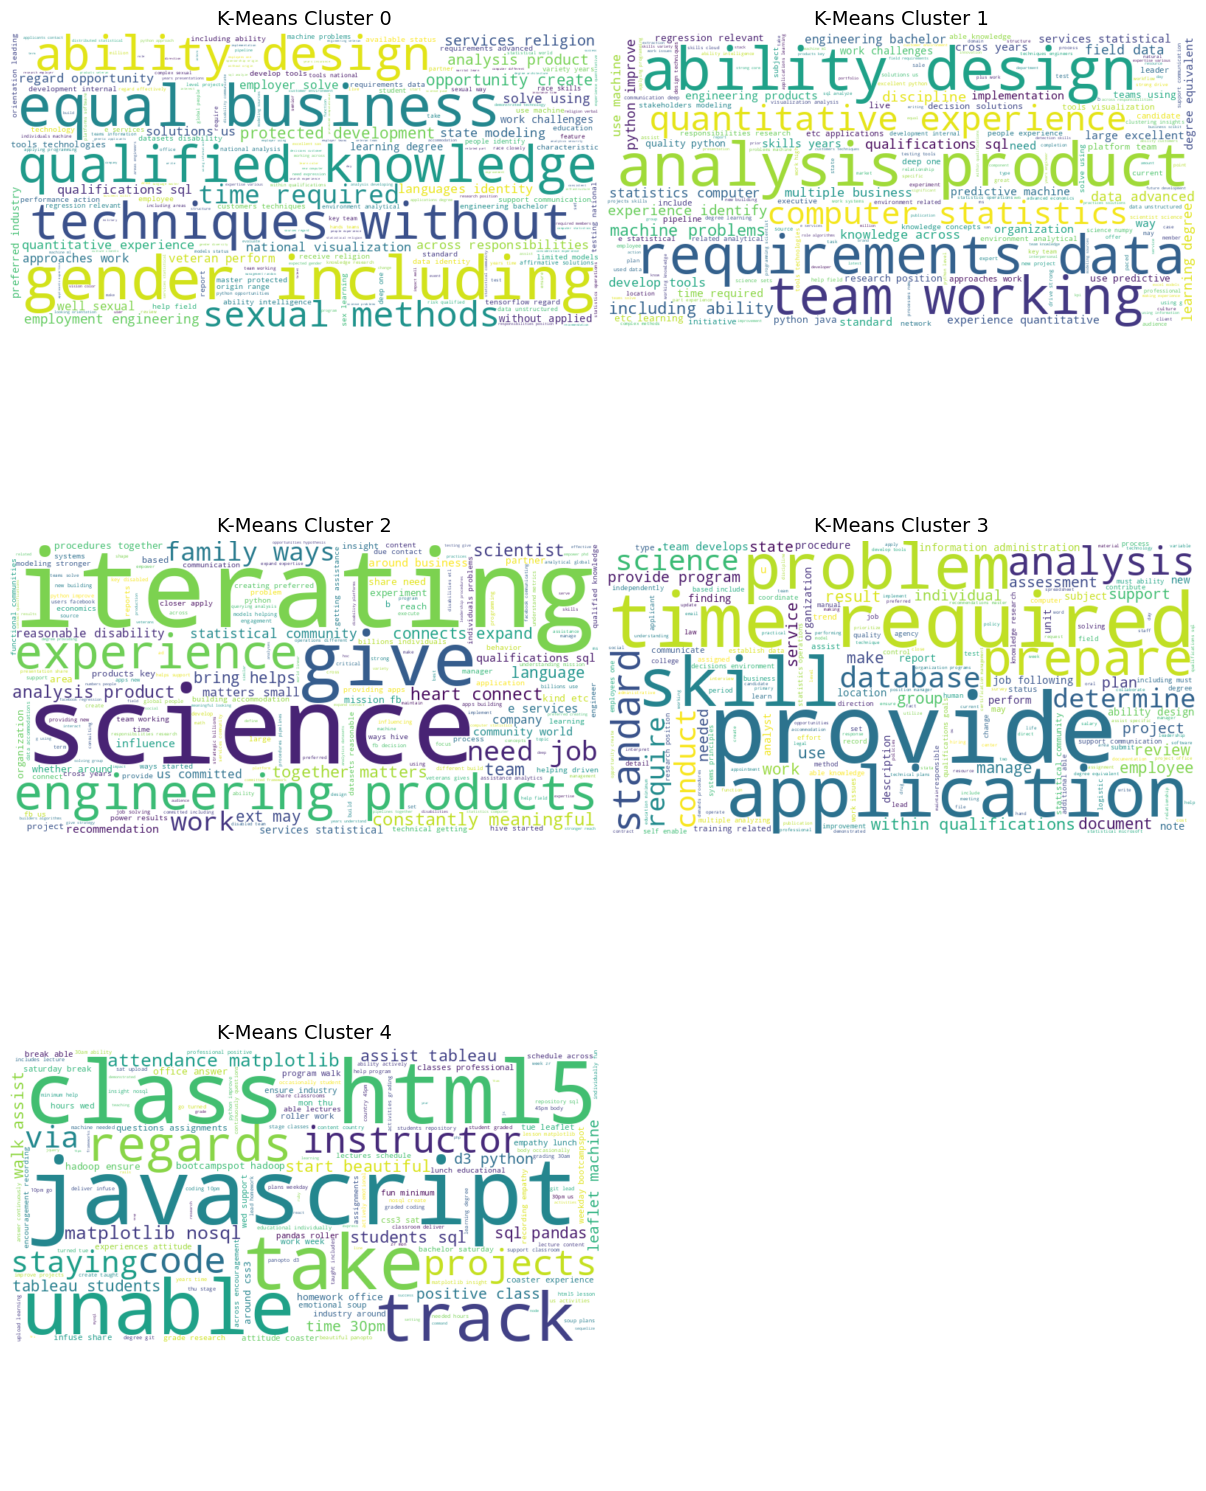

In [23]:
def plot_wordclouds_subplots(df, cluster_col, title_prefix, max_clusters=6):
    """
    Generates word clouds in a single figure with 3 rows x 2 columns of subplots,
    with reduced vertical/horizontal spacing.
    
    Parameters
    ----------
    df : pandas.DataFrame
        Must contain columns [cluster_col, "tag_text"]
    cluster_col : str
        Name of the column in df containing the cluster labels
    title_prefix : str
        A prefix to show in each subplot title, e.g., "K-Means" or "Agglomerative"
    max_clusters : int
        Maximum number of clusters (and subplots) to display (default 6).
    """
    # Identify the unique cluster labels and sort them
    clusters = sorted(df[cluster_col].unique())
    
    # Create a figure with 3 rows x 2 columns
    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 16), facecolor="white")
    axes = axes.flatten()  # flatten to a 1D array for easy indexing
    
    for i, cluster_id in enumerate(clusters[:max_clusters]):
        # Filter rows for this cluster
        subset_texts = df.loc[df[cluster_col] == cluster_id, "tag_text"]
        combined_text = " ".join(subset_texts)
        
        # Generate word cloud with white background
        wordcloud = WordCloud(width=800, height=400, background_color="white").generate(combined_text)
        
        # Plot on the i-th subplot
        ax = axes[i]
        ax.imshow(wordcloud, interpolation="bilinear")
        ax.axis("off")
        ax.set_title(f"{title_prefix} Cluster {cluster_id}", fontsize=14)
    
    # If there are fewer than 6 clusters, turn off the extra subplots
    for j in range(i+1, len(axes)):
        axes[j].axis("off")
    
    # Adjust spacing between subplots; tweak these values as needed
    fig.tight_layout(pad=0.5, w_pad=0.5, h_pad=0.8)
    
    plt.show()


# 1) K-Means Word Clouds
plot_wordclouds_subplots(
    df=df, 
    cluster_col="k_means_cluster_label", 
    title_prefix="K-Means",
    max_clusters=6  # up to 6 subplots (3 rows x 2 columns)
)

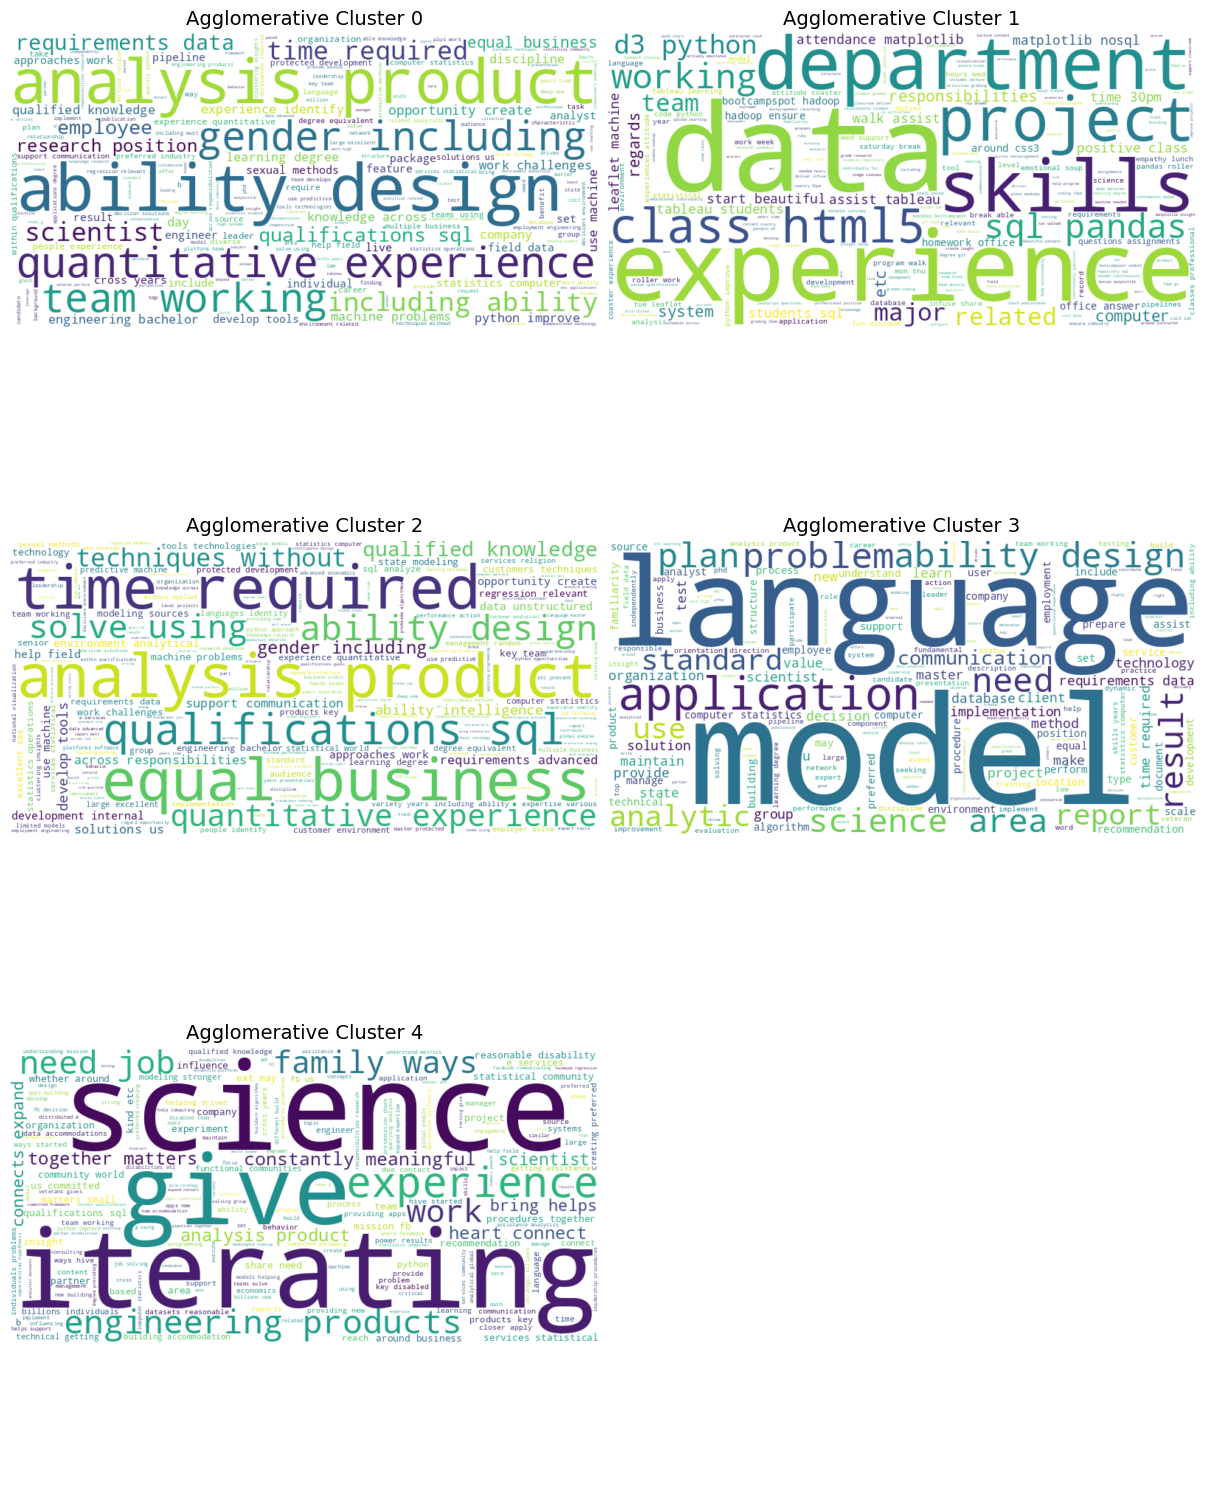

In [24]:
# 2) Agglomerative Word Clouds
plot_wordclouds_subplots(
    df=df, 
    cluster_col="agglo_cluster_label", 
    title_prefix="Agglomerative",
    max_clusters=6  # up to 6 subplots
)

### Compare clusters with resume.txt

In [25]:
resume_path = "./data/resume.txt"
with open(resume_path, 'r', encoding='utf-8') as f:
    resume_text = f.read()

# Potentially relevant DS/ML/Analysis skill keywords
potential_skills = [
    "python", "r", "sql", "java", "c++", "machine learning", "ml", 
    "deep learning", "nlp", "ai", "tensorflow", "pytorch", 
    "statistics", "power bi", "tableau", "spark", 
    "hadoop", "excel", "azure", "aws", "gcp", "pandas", "numpy"
]

resume_lower = resume_text.lower()

resume_skills = set()
for skill in potential_skills:
    if skill in resume_lower:
        resume_skills.add(skill)

print("Skills found in resume:\n", resume_skills)

Skills found in resume:
 {'nlp', 'numpy', 'pandas', 'r'}


In [26]:
def get_top_terms_per_cluster(df, cluster_label_col, top_n=10):
    """
    Returns a dictionary:
       cluster_id -> list of top_n token strings
    """
    cluster_terms = {}
    for cluster_id in sorted(df[cluster_label_col].unique()):
        # Get all tokens from rows in this cluster
        subset_tokens = df.loc[df[cluster_label_col] == cluster_id, "tag_tokens"]
        
        # Flatten the list of lists
        all_tokens = []
        for tokens in subset_tokens:
            all_tokens.extend(tokens)
        
        # Count frequency
        freq_counter = Counter(all_tokens)
        
        # Top N
        top_terms = [term for term, freq in freq_counter.most_common(top_n)]
        
        cluster_terms[cluster_id] = top_terms
    
    return cluster_terms

# Get the top 10 terms for each K-Means cluster
kmeans_top_terms = get_top_terms_per_cluster(df, "k_means_cluster_label", top_n=10)
kmeans_top_terms

{0: ['data',
  'experience',
  'work',
  'status',
  'race',
  'national',
  'disability',
  'religion',
  'origin',
  'orientation'],
 1: ['data',
  'experience',
  'skills',
  'python',
  'work',
  'analysis',
  'science',
  'team',
  'years',
  'learning'],
 2: ['products',
  'disabled',
  'working',
  'qualified',
  'responsibilities',
  'ways',
  'teams',
  'com',
  'minimum',
  'power'],
 3: ['data',
  'experience',
  'work',
  'skills',
  'related',
  'knowledge',
  'education',
  'qualifications',
  'required',
  'information'],
 4: ['machine',
  'activities',
  'soup',
  'class',
  'html5',
  'bootcampspot',
  'hadoop',
  'matplotlib',
  'nosql',
  'ensure']}

In [27]:
for cluster_id, terms in kmeans_top_terms.items():
    terms_set = set(terms)  # for easy set operations
    
    # Which terms are *already* in your resume?
    overlap = terms_set.intersection(resume_skills)
    
    # Which terms are *missing* from your resume?
    missing = terms_set - resume_skills
    
    print(f"\nK-Means Cluster {cluster_id}")
    print("Top Terms:", terms)
    print("Already in Resume:", overlap)
    print("Potential Missing Skills:", missing)


K-Means Cluster 0
Top Terms: ['data', 'experience', 'work', 'status', 'race', 'national', 'disability', 'religion', 'origin', 'orientation']
Already in Resume: set()
Potential Missing Skills: {'race', 'disability', 'national', 'work', 'experience', 'data', 'orientation', 'status', 'origin', 'religion'}

K-Means Cluster 1
Top Terms: ['data', 'experience', 'skills', 'python', 'work', 'analysis', 'science', 'team', 'years', 'learning']
Already in Resume: set()
Potential Missing Skills: {'team', 'skills', 'work', 'data', 'experience', 'years', 'analysis', 'science', 'learning', 'python'}

K-Means Cluster 2
Top Terms: ['products', 'disabled', 'working', 'qualified', 'responsibilities', 'ways', 'teams', 'com', 'minimum', 'power']
Already in Resume: set()
Potential Missing Skills: {'products', 'disabled', 'teams', 'working', 'qualified', 'responsibilities', 'com', 'ways', 'minimum', 'power'}

K-Means Cluster 3
Top Terms: ['data', 'experience', 'work', 'skills', 'related', 'knowledge', 'educa

In [28]:
# Repeat for Agglomoerative Clusters
agglo_top_terms = get_top_terms_per_cluster(df, "agglo_cluster_label", top_n=10)

for cluster_id, terms in agglo_top_terms.items():
    terms_set = set(terms)
    overlap = terms_set.intersection(resume_skills)
    missing = terms_set - resume_skills
    
    print(f"\nAgglomerative Cluster {cluster_id}")
    print("Top Terms:", terms)
    print("Already in Resume:", overlap)
    print("Potential Missing Skills:", missing)


Agglomerative Cluster 0
Top Terms: ['data', 'experience', 'work', 'skills', 'team', 'analysis', 'science', 'python', 'ability', 'years']
Already in Resume: set()
Potential Missing Skills: {'team', 'ability', 'skills', 'work', 'experience', 'data', 'years', 'analysis', 'science', 'python'}

Agglomerative Cluster 1
Top Terms: ['python', 'experience', 'learning', 'data', 'machine', 'matplotlib', 'pandas', 'assist', 'work', 'hadoop']
Already in Resume: {'pandas'}
Potential Missing Skills: {'machine', 'hadoop', 'experience', 'work', 'data', 'matplotlib', 'assist', 'learning', 'python'}

Agglomerative Cluster 2
Top Terms: ['data', 'experience', 'business', 'work', 'skills', 'python', 'science', 'team', 'analytics', 'statistical']
Already in Resume: set()
Potential Missing Skills: {'analytics', 'team', 'skills', 'work', 'business', 'experience', 'data', 'science', 'statistical', 'python'}

Agglomerative Cluster 3
Top Terms: ['data', 'experience', 'skills', 'work', 'analysis', 'years', 'scien

agglo_cluster_label      0   1    2    3   4
k_means_cluster_label                       
0                      144   1   95   33   0
1                      180  15  126  225   1
2                        0   0    0    0  26
3                       31  11    5   64   0
4                        0  10    0    0   0 



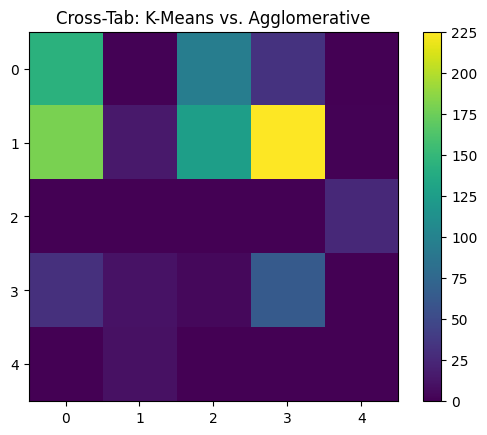

In [29]:
# Suppose your DataFrame is called 'df' and has columns:
# "k_means_cluster_label" and "agglo_cluster_label"

crosstab = pd.crosstab(df["k_means_cluster_label"], df["agglo_cluster_label"])
print(crosstab, '\n')
fig, ax = plt.subplots()
im = ax.imshow(crosstab.values)

# Label the ticks
ax.set_xticks(range(len(crosstab.columns)))
ax.set_yticks(range(len(crosstab.index)))
ax.set_xticklabels(crosstab.columns)
ax.set_yticklabels(crosstab.index)

plt.title("Cross-Tab: K-Means vs. Agglomerative")
plt.colorbar(im)  # optional
plt.show()